# Using an artificial neural network to classify Palmer Penguins 🐧 by species

[Palmer Penguins](https://allisonhorst.github.io/palmerpenguins/) is a dataset consisting of penguin measurements from the Palmer Archipelago in Antarctica. This notebook demonstrates the process to classify this data to species ([Adelie](https://www.antarctica.gov.au/about-antarctica/animals/penguins/adelie-penguin/), [Chinstrap](https://www.antarctica.gov.au/about-antarctica/animals/penguins/chinstrap-penguin/), or [Gentoo](https://www.antarctica.gov.au/about-antarctica/animals/penguins/gentoo-penguin/)) based on bill length, bill depth, flipper length, and body mass using a neural network model.

[![Latest release](https://badgen.net/github/release/Naereen/Strapdown.js)](https://github.com/dmhuehol/palmerpenguins-classifiers)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1FmPDIxYamEPOYhywqZSZbtyL3cwZsxk8?usp=sharing)


*    Example by [Daniel Hueholt](https://hueholt.earth), PhD student at Colorado State University (CSU)
*    Borrows format from the [CSU Machine Learning Tutorial](https://zenodo.org/record/6686879)
*    For details on Palmer Penguins and cute penguin art, see the official [Palmer Penguins page at GitHub](https://allisonhorst.github.io/palmerpenguins/) or [Horst et al. 2022](doi.org/10.32614/RJ-2022-020)


In [123]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
print('IN_COLAB = ' + str(IN_COLAB))

IN_COLAB = True


In [124]:
import matplotlib.pyplot as plt
import numpy as np
!pip install palmerpenguins # Dataset
from palmerpenguins import load_penguins
import pandas as pd # For confusion matrix
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.pipeline import FeatureUnion, make_pipeline
from sklearn import metrics
import sys
import tensorflow as tf

print(f"python version = {sys.version}")
print(f"scikit-learn version = {sklearn.__version__}")

python version = 3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]
scikit-learn version = 1.2.2


# 1. Load and look at data

In [125]:
X,y = load_penguins(return_X_y=True, drop_na=True) #drop_na removes observations with NaN values
print('--- FEATURES ---')
print(X.head())
feature_names = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']
print('--- LABELS ---')
print(y.head())
class_names = ['Adelie', 'Chinstrap', 'Gentoo'] # These are the penguin species

y = y.replace(to_replace='Adelie', value=0)
y = y.replace(to_replace='Chinstrap', value=1)
y = y.replace(to_replace='Gentoo', value=2)

--- FEATURES ---
   bill_length_mm  bill_depth_mm  flipper_length_mm  body_mass_g
0            39.1           18.7              181.0       3750.0
1            39.5           17.4              186.0       3800.0
2            40.3           18.0              195.0       3250.0
4            36.7           19.3              193.0       3450.0
5            39.3           20.6              190.0       3650.0
--- LABELS ---
0    Adelie
1    Adelie
2    Adelie
4    Adelie
5    Adelie
Name: species, dtype: object


We use the features (called `X`) to classify the data by target/label (called `y`). With this data, our targets/labels are the species of each penguin, while our features are physical measurements from each penguin.

We need to split the data into **training, validation, and testing datasets**. With Earth science data, we often need to carefully consider the method we use for this in order to prevent "data leakage" between these data splits. With penguins, this isn't a concern--so we can just use Scikit's default method to do this!

In [126]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=100,
                                                          random_state=13) # first reserve the held-back testing data
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=100,
                                                       random_state=13) # then reserve the validation data (for hyperparameter tuning)

# Commented lines below are to look at the split data
# print('--- TRAINING ---')
# print(X_train.head(), y_train.head())
# print('--- VALIDATION ---')
# print(X_val.head(), y_val.head())
# print('--- HELD-BACK TESTING --- ')
# print(X_test.head(), y_test.head())

We now have the following variables:


*   `X_train` and `y_train`: features and labels used for training
*   `X_val` and `y_val`: features and labels used for validation (hyperparameter tuning)
*   `X_test` and `y_test`: features and labels held back for testing

As neural networks often perform poorly on input data that is not standardized, we rescale the features to be normally distributed. Here, we employ the StandardScaler method from scikit-learn. We could do this manually by subtracting the mean and dividing by the variance (essentially calculating the z-score).

In [127]:
scaler = sklearn.preprocessing.StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_val_norm = scaler.fit_transform(X_val)
X_test_norm = scaler.fit_transform(X_test)

We can observe the impact of this scaling by plotting the histograms of the data. The penguin's mass measurements (weights in grams) are distributed very differently from the flipper and bill measurements (lengths in mm). Normalizing the data ensures that the network isn't confused by these differing values!

Text(0.5, 1.0, 'Normalized')

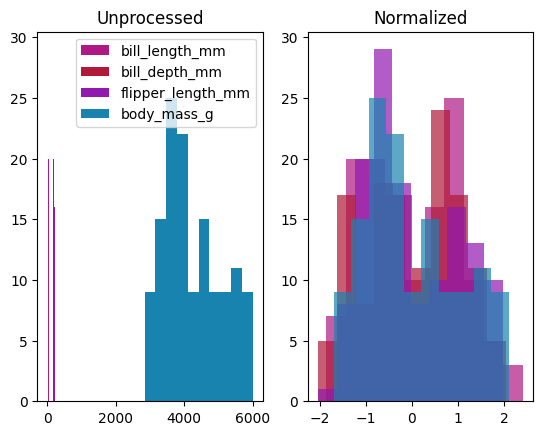

In [128]:
plt.subplot(1,2,1)
plt.hist(X_train.bill_length_mm, color='#b01983', label='bill_length_mm')
plt.hist(X_train.bill_depth_mm, color='#b01937', label='bill_depth_mm')
plt.hist(X_train.flipper_length_mm, color='#9219b0', label='flipper_length_mm')
plt.hist(X_train.body_mass_g, color='#1983b0', label='body_mass_g')
plt.legend()
plt.title('Unprocessed')
plt.subplot(1,2,2)
plt.hist(X_train_norm[:,0], color='#b01983', alpha=0.7, label='bill_length_mm')
plt.hist(X_train_norm[:,1], color='#b01937', alpha=0.7, label='bill_depth_mm')
plt.hist(X_train_norm[:,2], color='#9219b0', alpha=0.7, label='flipper_length_mm')
plt.hist(X_train_norm[:,3], color='#1983b0', alpha=0.7, label='body_mass_g')
plt.title('Normalized')

Additionally, we need to set up our integer labels in the format that tensorflow can understand.

In [140]:
y_train_cat = tf.keras.utils.to_categorical(y_train.values,3)
y_val_cat = tf.keras.utils.to_categorical(y_val.values,3)
y_test_cat = tf.keras.utils.to_categorical(y_test.values,3)

Now we are ready to set up the artificial neural network!

# 2. Set up and run the artificial neural network

We define the tunable parameters (hyperparameters) that we'll use for the model. We put these values in a dictionary so they can easily be accessed and modified for future experiments. Neural networks have an enormous number of hyperparameters. Most can only be determined through trial and error--this process can often be a major portion of a research project that uses NN methods! Developing efficient ways to conduct hyperparameter searches is a very active area of computer science research.



*   **loss:** Function to be minimized during training. Valid options in tensorflow documentation [here](https://tensorflow.org/api_docs/python/tf/keras/losses); `CategoricalCrossentropy` is often good for multiclass classification.
*   **metric:** Function used to evaluate performance. Valid options in tensorflow documentation [here](https://tensorflow.org/api_docs/python/tf/keras/metrics); `accuracy` often good for classification problems.
*   **hidden_nodes:** A list giving the nodes for each hidden layer.
*   **out_nodes:** Nodes for output layer. For classification problems, this should be equal to the number of classes (thus, for our penguins, this must be 3).
*   **rnd_state:** Seed value set to allow reproducibility of exact results.
*   **activations:** Dictionary setting activation functions for hidden node and output node. In classification problems, `relu` is standard for hidden nodes and `softmax` for output. [This article at Machine Learning Mastery](https://machinelearningmastery.com/choose-an-activation-function-for-deep-learning/) is useful to learn more!
*   **num_epochs:** Number of epochs to train model.
*   **batch_size:** Amount of samples to pass into the model before updating weights. The best batch size varies from problem to problem, but 32 is often a good starting point.
*   **learn_rate:** Rate at which the model moves down the gradient of the loss function. Too large of a learning rate runs the risk of diverging; too small of a learning rate may become "stuck" in local minima.
*   **initializer:** Method by which random weights are initialized. Valid options in tensorflow documentation [here](https://www.tensorflow.org/api_docs/python/tf/keras/initializers).
*   **regularizer:** Methods to constrain model parameters and make overfitting less likely. May not be needed for every problem. Valid options in tensorflow documentation [here](https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/).
*   **early_stop:** Stop model training if it begins to overfit to the training data (e.g., training loss is decreasing, but validation accuracy is also decreasing). The "patience" option sets the number of epochs that the early stopping condition can occur before the model is ended.
*   **verbosity**: 1/0 option to output/not output information to the console.
*   **class_weight**: Dictionary option to weight certain classes to be treated as "more important" during training. Often critical to good performance when classes are very imbalanced, and less important when there are similar number of samples in each class (as for our penguins). See description [here](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data).



In [169]:
nnd = {
    "loss": tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    "metric": 'accuracy',
    "hidden_nodes": [10,],
    "out_nodes": 3,
    "rnd_state": 13,
    "activations": {"hid": 'relu',
                    "out": 'softmax'},
    "num_epochs": 50,
    "batch_size": 32,
    "learn_rate": 0.01,
    "initializer": tf.keras.initializers.RandomNormal,
    "regularizer": None,
    "early_stop": tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy', patience=20, verbose=1, mode='auto',
        restore_best_weights=True),
    "verbosity": 1,
    "class_weight": None #
}

### Default values retained below for reference
# nnd = {
#     "loss": tf.keras.losses.CategoricalCrossentropy(from_logits=True),
#     "metric": 'accuracy',
#     "hidden_nodes": [10,],
#     "out_nodes": 3,
#     "rnd_state": 13,
#     "activations": {"hid": 'relu',
#                     "out": 'softmax'},
#     "num_epochs": 50,
#     "batch_size": 32,
#     "learn_rate": 0.01,
#     "initializer": tf.keras.initializers.RandomNormal,
#     "regularizer": None,
#     "early_stop": tf.keras.callbacks.EarlyStopping(
#         monitor='val_accuracy', patience=20, verbose=1, mode='auto',
#         restore_best_weights=True),
#     "verbosity": 1,
#     "class_weight": None #
# }

We set up the NN classifier to use the hyperparameters we just specified.

In [170]:
def compile_model(train_feat, nnd):
  input_layer = tf.keras.Input(shape=np.shape(train_feat[0,:]))
  for lc, nodes in enumerate(nnd["hidden_nodes"]):
    if lc == 0:
      hid_layer = tf.keras.layers.Dense(
          nodes, activation=nnd["activations"]["hid"],
          kernel_initializer=nnd["initializer"](seed=nnd["rnd_state"]),
          kernel_regularizer=nnd["regularizer"])(input_layer)
    else:
      hid_layer = tf.keras.layers.Dense(
          nodes, activation=nnd["activations"]["hid"],
          kernel_initializer=nnd["initializer"](seed=nnd["rnd_state"]),
          kernel_regularizer=nnd["regularizer"])(hid_layer)
  out = tf.keras.layers.Dense(
      nnd["out_nodes"], activation=nnd["activations"]["out"],
      kernel_initializer=nnd["initializer"](seed=nnd["rnd_state"]))(hid_layer)
  model = tf.keras.models.Model(inputs=[input_layer], outputs=out)
  optimizer = tf.keras.optimizers.Adam(learning_rate=nnd["learn_rate"])
  model.compile(
      loss=nnd["loss"], optimizer=optimizer, metrics=[nnd["metric"]])
  model.summary()

  return model

def fit_model(
    model, train_feat, train_lab, val_feat, val_lab, nnd):
  history = model.fit(train_feat, train_lab, epochs=nnd["num_epochs"],
                      verbose=nnd["verbosity"], batch_size=nnd["batch_size"],
                      shuffle=True, validation_data=(val_feat, val_lab),
                      class_weight=nnd["class_weight"], callbacks=nnd["early_stop"])
  return history

def train_model(train_feat, train_lab, val_feat, val_lab, nnd):
  tf.random.set_seed(nnd["rnd_state"])
  model = compile_model(train_feat, nnd)
  history = fit_model(
      model, train_feat, train_lab, val_feat, val_lab, nnd)
  return model, history.history


In [171]:
nn_model, history = train_model(
    X_train_norm, y_train_cat, X_val_norm, y_val_cat, nnd)

Model: "model_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_27 (InputLayer)       [(None, 4)]               0         
                                                                 
 dense_77 (Dense)            (None, 10)                50        
                                                                 
 dense_78 (Dense)            (None, 3)                 33        
                                                                 
Total params: 83 (332.00 Byte)
Trainable params: 83 (332.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5562: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


67/67 [==============================] - 1s 6ms/step - loss: 1.0521 - accuracy: 0.4586 - val_loss: 1.0139 - val_accuracy: 0.3800
Epoch 2/50
67/67 [==============================] - 0s 3ms/step - loss: 0.9208 - accuracy: 0.6692 - val_loss: 0.8739 - val_accuracy: 0.7600
Epoch 3/50
67/67 [==============================] - 0s 4ms/step - loss: 0.7445 - accuracy: 0.8271 - val_loss: 0.7375 - val_accuracy: 0.7600
Epoch 4/50
67/67 [==============================] - 0s 4ms/step - loss: 0.5836 - accuracy: 0.8271 - val_loss: 0.6129 - val_accuracy: 0.7600
Epoch 5/50
67/67 [==============================] - 0s 3ms/step - loss: 0.4626 - accuracy: 0.8271 - val_loss: 0.5209 - val_accuracy: 0.7600
Epoch 6/50
67/67 [==============================] - 0s 4ms/step - loss: 0.3873 - accuracy: 0.8271 - val_loss: 0.4598 - val_accuracy: 0.7600
Epoch 7/50
67/67 [==============================] - 0s 3ms/step - loss: 0.3419 - accuracy: 0.8271 - val_loss: 0.4212 - val_accuracy: 0.7600
Epoch 8/50
67/67 [=============

In [172]:
y_pred_train = nn_model.predict(X_train_norm)
y_pred_val = nn_model.predict(X_val)

4/4 [==============================] - 0s 3ms/step


Let's check and see how well we did on the training data using the accuracy score and a confusion matrix.

training accuracy:  99.0 %


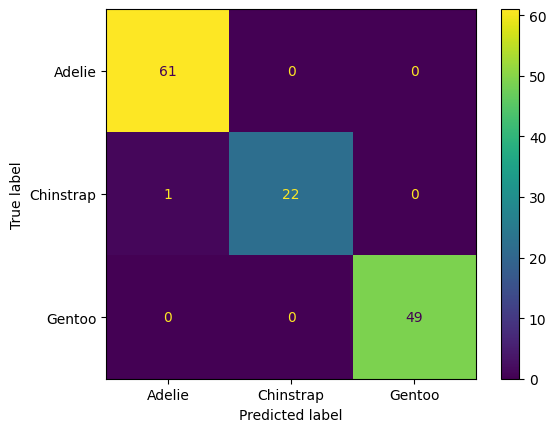

In [173]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# print(y_pred_train) #Confidence in each class
y_pclass_train = np.argmax(y_pred_train, axis=1) #Element of maximum confidence

acc = metrics.accuracy_score(y_train, y_pclass_train)
print("training accuracy: ", np.around(acc*100), '%')

cm = confusion_matrix(y_train, y_pclass_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot()

Now let's try the validation data, to make sure our model applies to data it hasn't seen before.

4/4 [==============================] - 0s 3ms/step
validation accuracy:  99.0 %


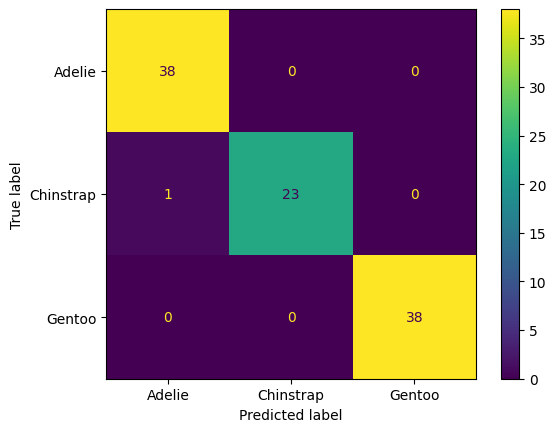

In [146]:
y_pred_val = nn_model.predict(X_val_norm)
y_pclass_val = np.argmax(y_pred_val, axis=1) #Element of maximum confidence

acc = metrics.accuracy_score(y_val, y_pclass_val)
print("validation accuracy: ", np.around(acc*100), '%')
cm = confusion_matrix(y_val, y_pclass_val)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot()

Continue tuning the hyperparameters until you're happy with the validation accuracy. Since the data is linearly separable, it's very difficult to find anything better than the simple support vector machine implemented with the settings provided above!

Once you are happy with your model, you can once (and only once!) apply your model on the testing data. Before we do that, it's useful to try to understand how the model makes its decisions. This helps you to check whether it's overfitting, not successfully making decisions, or is ready to roll!

# 3. Explainability

Right now, we don't know why the ANN is making its predictions (i.e. it is a "black box"). There are many methods to explain the network's behavior--someday those will be implemented here!

# 4. Run ANN classifier on testing data

Once you're happy with your model in its final form, run your ANN on the testing data!

4/4 [==============================] - 0s 3ms/step
held-back testing accuracy:  98.0 *


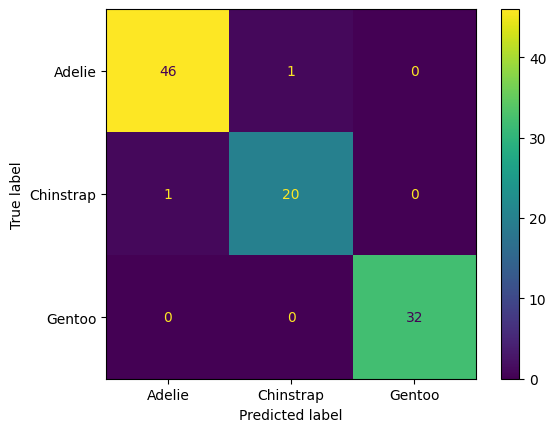

In [151]:
y_pred_test = nn_model.predict(X_test_norm)
y_pclass_test = np.argmax(y_pred_test, axis=1) #Element of maximum confidence

acc = metrics.accuracy_score(y_test, y_pclass_test)
print("held-back testing accuracy: ", np.around(acc*100), '*')
cm = confusion_matrix(y_test, y_pclass_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot()
plt.grid(False)
plt.show()

🐧